In [137]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import time 

In [146]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                # x_Y = U + 0.5
                x_Y = [-1]*indiv + U + A + df.groupby(["indiv"]).A.mean()
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [123]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [124]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model = {}
    poly = PolynomialFeatures(1)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            x = temp_df[["L1_1", "A_1"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), poly.fit_transform(x)).fit(); 
        elif ii == 2: 
            x = temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # poly.fit_transform(x)).fit(); 
        else: 
            x = temp_df[train_columns]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # np.asarray(sm.add_constant())).fit(); 
        L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       poly.fit_transform(x)).fit(); 
    return(L1_model)

In [95]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    train_columns = ["L1", "L1_1", "L1_2", "A_1", "A_2", "A_3"]
    A_model = {}
    poly = PolynomialFeatures(1)
            
    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            x = temp_df[["L1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), sm.add_constant(x, has_constant = "add")).fit()
        elif ii == 1: 
            x = temp_df[["L1", "L1_1", "A_1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        elif ii == 2:
            x = temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        else: 
            x = temp_df[train_columns]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
    return(A_model)


In [131]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 
    
    L_model = covariate_model_creation(df, max_time)
    poly = PolynomialFeatures(1)

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    x = np.transpose(np.array([list(values[0]),[A_test[0]]*reps]))
    values[1] = L_model[1].predict(poly.fit_transform(x))
    #np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                # np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    
    p_v = sp.special.expit(values[1])
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    x = np.transpose(np.array([list(values[1]),list(values[0]), [A_test[1]]*reps, [A_test[0]]*reps]))
    values[2] = L_model[2].predict(poly.fit_transform(x))
                # np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                # np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                # [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = sp.special.expit(values[2]) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        x = np.transpose(np.array([list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps]))
        values[jj] = L_model[jj].predict(poly.fit_transform(x))
                     # np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     # *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     # list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     # [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = sp.special.expit(values[jj]) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = sp.special.expit(Y_exp)
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [7]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [8]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [9]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [10]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [11]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [164]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

alpha_model_right = [False]*12
s_model_right = [False]*12
alpha_model_good = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]

    
    for kk in range(0,max_time+1):
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    # time_dr = time_dr + time.time() - start_time

    results_effect.loc[len(results_effect)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
results_effect.to_csv("W_EFFECT_RESULTS_FINAL")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.592973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681662


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.596177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685779


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.613479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687595


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.580874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685527


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.606131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690808
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683176


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.596089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683266


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.593203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681664


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.597591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690181
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680140


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.614644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685920


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.603136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683416


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.600021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686218

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.606043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.593818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692213
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.589270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.610243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.585857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.617723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.597299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.573080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.623764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.592407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689935

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.605579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689601
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.606066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.608389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.604401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.620900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685370

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.602654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.623083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686739

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.585311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.612995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.620730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.598477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680773

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.633365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689375

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.588267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.615124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.609151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.609015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.600022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691989
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.608340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.594820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.611627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.588771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690896
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.603262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.591496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.597629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.597810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692459
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681449

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.623759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.626375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.602002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691624
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.588814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.594767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682336

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.619689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.582336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680940

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.620939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691042
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.624329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.614305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.616266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.615485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.622533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.617744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.621190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691567
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.600566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.599283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692491
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.595044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688739

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.615127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.598770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692898
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.619429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.624671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.609252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.620028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691837
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.622284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.592856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.611378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.613623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681858

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.572484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.588872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691783
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.598096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.604450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692309
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.594057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.612599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691243
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.609935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.598803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.614937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.603662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.593462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.600892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.614354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691590
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.600669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.604723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.605379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691845
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.593016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.612998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681723

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.609665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692225
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.604431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.621224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682126

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.616326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.619801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690807
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.590393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.603860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692570
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684645

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.600466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690229
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.618991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.596436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.600030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68690

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.599078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68625

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.614201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.610083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68998

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.630832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67676

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.622293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.611662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68523

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.616660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67998

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.623077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691415
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.602894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.604860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68523

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.630873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691842
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.581182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67517

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.635462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.596295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.585219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.590728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692010
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.590848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691827
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.607680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.590556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.621861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.594407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.629568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68478

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.614625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68294

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.605472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68550

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.578379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691385
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.69166

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.606219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.611859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.613780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68408

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.616596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691680
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68476

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.616475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692201
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.592252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.603603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.604927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.589994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.619327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.626252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691960
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.588122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.615302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.618716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68448

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.595981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68253

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.613296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.594299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.613193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.601282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.609248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.595451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68362

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.610673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68831

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.595921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.624866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68568

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.601330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68573

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.622208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68287

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.601318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.601522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.587819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.603411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.590774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.600578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.592701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.625671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.623494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691415
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.603527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.605867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692996
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.604050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68392

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.612953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.599728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691591
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.620012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68979

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.601967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.610787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.603557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.595862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.606198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.605009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.604308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68408

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.606111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.586441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.595882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.576463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.615030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67449

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.603090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.594627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691018
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.614381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68454

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.579372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.610872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691658
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.613299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.604750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68392

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.602628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.616674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.620728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68326

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.575096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.620171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.596597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.603728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.617107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691638
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.604931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68279

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.621675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.610029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68549

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.622888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.591865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.604951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.603876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.605711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.609707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.632113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692578
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68739

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.602778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.604422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.608278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.622120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68645

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.607828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.588108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692504
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.591356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.597574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.606649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.608569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.599750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68486

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.590970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.607028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.587429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.593432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.605121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68237

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.617814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.601834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69004

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.578863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.593446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.621167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691757
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.603271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.602533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.613812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.599053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68741

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.599095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.595124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68500

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.616901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.600448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.632017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.613156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.609433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691932
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.615633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.603636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.624538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67982

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.624946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.605954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692436
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.613438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.580275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.614110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691243
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.594926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.592193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.599022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.598141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691865
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.598425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.613053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68216

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.622200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.593911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.591646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691506
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.619329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692708
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.595149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.619955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.602554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68554

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.608541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691331
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68377

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.615074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.580825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690954
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.613076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68568

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.625327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.618032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.614601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.586121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68267

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.623030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.614406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.600495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692205
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.609802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.601611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.594532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.626532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690671
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.585536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.607355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691164
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691475
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.597711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.626015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68437

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.591887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68600

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.623692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690635
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.618961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.610115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.579107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.613104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.586868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.593878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.606345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691435
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.610477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.605494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.609048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690024
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.623093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67723

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.599493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68780

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.603389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.598077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68555

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.618328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.598707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.598800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.594967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.603709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68688

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.602281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.613364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691389
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68636

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.610359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.594452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68413

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.607639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.605548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.591217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.598873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.618680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.583677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692996
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.620700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.614754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67107

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.609979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691844
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.623318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.593896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691905
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.603308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.595770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.594864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.607713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.612293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.601281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.591928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.584884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.603736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692613
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.632887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68173

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.628757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68530

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.620660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.601435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.622485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.592039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692031
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68619

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.608446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691607
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.611330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692193
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.593750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.611637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.599694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.602752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691338
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.601940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.615386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.585842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690759
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.593981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691804
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.596628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.604962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.602658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68639

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.587605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.593791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68286

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.599952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692022
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68130

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.613529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68538

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.592831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68546

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.612796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.622661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.618293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.619817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.605477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.601584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.607308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.608086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.614607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692200
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.596595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.599514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.585665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.594179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692640
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.629756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69027

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.603969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.602758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.626473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692309
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68273

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.594286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.609933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68092

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.594517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692447
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.609196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.606523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.594475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67943

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.589193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.622458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.589472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68159

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.604108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.587443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.637840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.607832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.597935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.594571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.610825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.602995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692053
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.601281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.608305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.609018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.592968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.597643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68437

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.600965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.618365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.607341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67956

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.605044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68482

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.622850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.609452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.598501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691499
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.611686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.611819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.603157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690298
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.596840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69115

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.597935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.619730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.608314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691338
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.604786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.613097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.601211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.606290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68881

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.586218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.590189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.584773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.609969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.614763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691601
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.595078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.595016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687302
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.580101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689252
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.614943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.604832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691586
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.607717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.592173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.595274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.620403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691397
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.598862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.612312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.618895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.613277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.584485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67853

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.609042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.595407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691887
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.621777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.618738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692818
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.611798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.599493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67946

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.615099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692154
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68973

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.615518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68959

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.616651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.616833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.613736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68855

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.609249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.627319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691329
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.606309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.612728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.600665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.606569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.598305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.596728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691262
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67938

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.600551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.619005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.592595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.587434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.603178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691163
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.617740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691573
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.596314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.609824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.604135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.595143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68381

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.598627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68669

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.592062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68333

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.596755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.619077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68318

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.604758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691908
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68639

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.623947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68481

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.607957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691132
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.597985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.611321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692078
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.618257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.605105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.602527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.627760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.609016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.604603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.612298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.602851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691504
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.615887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69023

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.606266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.594757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.614332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691650
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.630015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.595007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.604588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.621584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.591053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690875
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68324

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.602167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68526

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.609622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.616702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.603340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.586074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.602001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69025

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.580086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.592628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.583336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.613677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68025

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.620426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.584392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.595305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.616349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691530
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69055

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.593056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.607467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.605019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.617524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.620067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692395
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.600378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.621842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691562
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68390

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.611294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67995

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.619955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691560
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.604653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.613147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692092
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.610143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.608805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.601366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.606509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.599422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.598094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.599986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.612299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.591811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.603160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.632306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.604100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.600429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.615859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68804

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.607442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.609401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.598550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691373
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.618975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.606323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.602131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.592437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.600477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.604718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.612639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68373

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.587297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68743

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.616967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.601994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691812
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.617104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.597791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.600549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.615028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690776
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68561

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.616298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.606007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.616892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.589016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68953

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.591808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68834

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.609083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691553
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.614402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680839
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68318

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.583643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.595278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.591218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692197
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.596504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691760
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.621744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.606128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.607272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.624738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68978

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.610831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.603391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.578341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68195

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.612009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691793
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68590

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.607779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.592071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691562
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.602659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.618333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692721
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.609640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68582

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.599387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.595759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691688
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.600637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691211
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.595644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68959

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.610676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.605740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.613613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.611577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.611350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.613784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691291
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.615067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68606

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.623404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.615083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68316

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.599794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.597701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691467
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68730

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.612959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691666
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68672

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.612821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.614092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68092

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.603896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.596798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.592581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.590057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691505
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.594581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692907
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68706

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.615712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691594
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68702

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.631608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692397
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68205

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.603090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.601929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.599235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.599589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68604

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.600591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.604110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.585102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691351
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.606593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68733

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.598138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688623
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.609012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.612313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.606621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.612823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.603892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.602639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691234
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67495

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.588810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.610378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.615818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.593264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691953
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.576511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.605705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.616813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68671

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.624027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691370
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.614215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.576462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691244
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.622207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.598162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686509
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.588757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.607945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691233
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.600184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68839

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.626262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.605997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68733

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.584647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.597616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.622873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.615611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.622105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691315
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.613059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68252

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.602489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691988
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68693

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.600037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.575600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.608440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.604190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.602334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68716

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.601901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.608771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692399
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.623061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68331

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.606475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68199

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.605547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.613967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68272

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.618877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690789
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.616859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692277
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.590438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68473

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.617599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.616552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.611401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68710

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.600044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68283

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.616530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68987

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.600342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.589868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67888

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.604280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692252
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.609527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.609178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.593301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68412

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.624802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.625396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.621699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68089

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.594167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.597550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.595811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691161
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.584334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.614669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691837
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68579

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.598292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691068
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.607659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.606780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690829
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.614130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691621
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.623418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692098
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.594856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.602411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68424

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.619632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68633

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.604198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.66998

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.596487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691355
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.628064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68233

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.598693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.614831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683929
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691407
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.602790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691142
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68773

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.602820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691658
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68542

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.607473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.593846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684866
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68660

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.594738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.620732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.589344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68581

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.609507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.605610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689128
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.604312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.606132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690240
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.589768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.594160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690898
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.603704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.597907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.610258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.591945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68100

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.597423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.601214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.634004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.605445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.587738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68653

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.596402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692417
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.603303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.599608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692006
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.613296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685374
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67885

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.615315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.610138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.592565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.613251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.601987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.623904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.614933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.609219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.608962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.613007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.618325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691800
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68563

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.607563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.583035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685861
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68550

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.611340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.584344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.604562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68497

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.612880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.570157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67921

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.596196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67966

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.597930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.608790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.626426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68970

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.612630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68306

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.591845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.601877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.599657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686020
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.593633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68511

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.609014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.595730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.596531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691697
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.593820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691371
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68127

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.584318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691512
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.582548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.618063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68209

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.589369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691289
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.603631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690694
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.623038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.598389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68424

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.604231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.597427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687172
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683766
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68934

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.611408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691339
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68220

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.602388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.586183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.592708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.601584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.592628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691336
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.599144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.608490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.619545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687193
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.604025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68465

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.613902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.593543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692262
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.594399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.590640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.590394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691838
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.614055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.611320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.590217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67998

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.600791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.598166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.619201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67730

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.613529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.614123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68478

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.609490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.607924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691067
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.607718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688201
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.606277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.584894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686933
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689947
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.585592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68379

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.605530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.574622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.590083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690034
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.609834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.613228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691930
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.588972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.588559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68188

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.603372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688485
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.589012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69023

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.608516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.616355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693137
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68553

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.599388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68287

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.605212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68533

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.590406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68873

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.618119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691734
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.596627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.608634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68267

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.617309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691738
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68527

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.611517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68176

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.589857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682500
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.595783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.599415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691950
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.607572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.609738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691343
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.593181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681341
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677152
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.596175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.610827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687486
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.595842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.616461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.587478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687789
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.619289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.592924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.603947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68845

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.601328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.616041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68858

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.604753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.586605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691409
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683697
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.611039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.573984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692676
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.613819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691287
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.611990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.591956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.598822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692285
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.612495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681675
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.621352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691738
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687812
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.595439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.608863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.602324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690825
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.668042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.590303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.603907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.579454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.613001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685714
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.598184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690965
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.590430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.629061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.593400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.611800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68002

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.629386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.610029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692015
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.600562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.623967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691933
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.632502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.590748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691535
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68356

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.589281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.594813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.619213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.603730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.597018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684582
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.620450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678451
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.617978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684841
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.589896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691206
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.597767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.590348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.624719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.601872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.615420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684772
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.588413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.601127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.611073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691957
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.630656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692269
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685369
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.617079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.586077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68565

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.623223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.580219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677383
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679872
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.606530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.609280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691616
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.595668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.600796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.594731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.624859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.602671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68362

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.598765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686059
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.619214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691313
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.666752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67498

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.611378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680115
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68518

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.615918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691925
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680170
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.612654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68293

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.603768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.611279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.603900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691945
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.568788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678061
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679173
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68531

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.604023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.598190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676758
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.614928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.608622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68365

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.608780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691099
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680731
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683848
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.611329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.590003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686363
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.593767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.606078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689417
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.602218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.628404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684361
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.608272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685482
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.612581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68836

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.583252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.599627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.578349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686708
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.609405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691059
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68779

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.604224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.619077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691635
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.667985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.613702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691683
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.594839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684712
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.601922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.585664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691197
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.68395

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.611395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691864
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.582879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68543

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.603292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691316
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686359
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68499

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.626089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691753
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.628600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.603079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692794
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.679333
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.590631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.593649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682355
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686104
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.600800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.610207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.609773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686684
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.603258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690245
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.610738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.613570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691762
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.616489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.598654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.602370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.609177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692223
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68267

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.611870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.590955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.624825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682420
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677122
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.586705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691946
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.614201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683744
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68057

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.586896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686802
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.598292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691475
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.677528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688447
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.595680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691381
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.619915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692009
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.626549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68399

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.609651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682218
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68557

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.582791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676735
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691315
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691859
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.600930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.603015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691330
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.683312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684527
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.608870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691386
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.601344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68797

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.607516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688139
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692566
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.610613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692816
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68635

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.604173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691595
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.589806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.603470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683676
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.603171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691088
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685283
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687611
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68718

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.603752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.602374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.582171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.604807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682543
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688896
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.621995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.612284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.614143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679992
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.600188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691411
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687938
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.614291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691607
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.612019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692393
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.600854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686329
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68158

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.608636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684613
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.568478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689235
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670040
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68711

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.598380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691345
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685717
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.611738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686910
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68990

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.604282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.595510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690851
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.669318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682612
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.594208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686433
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682881
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.602987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688364
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.587343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691915
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689670
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67671

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.616014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687056
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67323

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.625111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.606723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.588377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692403
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681226
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68530

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.608341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682093
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688239
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679273
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.599759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68191

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.633912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.616696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68286

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.597324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68299

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.608372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687762
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68550

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.591400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.598625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.610153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.586573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690503
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68789

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.615076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.637034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671831
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690925
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.610387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688598
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.69059

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.608048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684939
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.599736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691773
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.674907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.598991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.617217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690057
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.590787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68999

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.608901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678354
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67970

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.604272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.586927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689581
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.581004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.581801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.596944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.603028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690196
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.605151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.581331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685651
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683269
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.620916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673699
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.602307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687189
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.608821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.598777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681874
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.600013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688879
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688927
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67791

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.605022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.611194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692084
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.67862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.619759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691451
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688949
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.589974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685988
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684609
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.588813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.626948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.624512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691684
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68646

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.618530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.617406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684068
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.591816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683155
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.588834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688475
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.598137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690773
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682291
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.612206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680942
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.68508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [173]:
print(np.mean(results_effect.differenceg))
print(np.mean(results_effect.differencedr))

0.00048581497854976644
0.2223443437906972


In [178]:
print(np.mean(results_effect.differenceg)-1.96*np.sqrt(np.var(results_effect.differenceg)/1000))
print(np.mean(results_effect.differenceg)+1.96*np.sqrt(np.var(results_effect.differenceg)/1000))
print(np.mean(results_effect.differencedr)-1.96*np.sqrt(np.var(results_effect.differencedr)/1000))
print(np.mean(results_effect.differencedr)+1.96*np.sqrt(np.var(results_effect.differencedr)/1000))

0.000470062706021
0.000501567251079
0.220436683294
0.224252004288


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1219]:
print(np.mean(results_effect_df2.differenceg) +1.96*np.sqrt(np.var(results_effect_df2.differenceg)/1000))
print(np.mean(results_effect_df2.differencedr) +1.96*np.sqrt(np.var(results_effect_df2.differencedr)/1000))
# results_effect_df2.head(100)

5.12580700345e-08
0.190098670895


In [1215]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [172]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools

# results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect.corrYA,
    y=results_effect.differencedr, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect.corrYL1,
    y=results_effect.differencedr, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect.corrAL1,
    y=results_effect.differencedr, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_effect.corrYA,
    y=results_effect.differenceg, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_effect.corrYL1,
    y=results_effect.differenceg, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_effect.corrAL1,
    y=results_effect.differenceg, 
    mode = "markers"
)




# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[0, 0.5])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[0, 0.5])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.2, 0.2])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.2, 0.2])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0, 0.2])

fig['layout']['yaxis1'].update(title='', range=[-0.05, 0.45])
fig['layout']['yaxis2'].update(title='', range=[-0.05, 0.4])
fig['layout']['yaxis3'].update(title='DR Causal Treatment Effect', range=[-0.05, 0.45])
fig['layout']['yaxis4'].update(title='G-formula Causal Treatment Effect', range=[-0.05, 0.45])
fig['layout']['yaxis5'].update(title='', range=[-0.05, 0.45])
fig['layout']['yaxis6'].update(title='', range=[-0.05, 0.45])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy</br> With Treatment Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots2')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [111]:
## TESTING NATURAL COUSE 
def natural_course_test(df): 
    max_time = 11
    indiv = 10000
    results_mean_df = pd.DataFrame(columns = list(df))
    results_var_df = pd.DataFrame(columns = list(df))
    Y_model = Y_model_creation(df, max_time)
    L_model = covariate_model_creation(df, max_time)
    A_model = treatment_model_creation(df, max_time)
    poly = PolynomialFeatures(1)
    poly2 = PolynomialFeatures(1)

    new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
    for ii in range(0, max_time+1): 
        # print(ii)
        if ii == 0: 
            L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

            A = A_model[ii].predict(sm.add_constant(L, has_constant='add'))

            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 1: 
            y = np.transpose(np.array([new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 2: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                    new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                    new_df[new_df["time"] == ii-2].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        else: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                     new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                      new_df[new_df["time"] == ii-3].A]))
            
            L = L_model[ii].predict(poly2.fit_transform(y))
            
            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, new_df[new_df["time"] == ii-3].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])
    for kk in range(1,max_time+1):
        new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
        new_df["A_"+str(kk)] = new_df.A.shift(kk)

    small_df = new_df[new_df["time"] == 11.0]
    cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
    small_df = small_df[cols]
    p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
    new_df.Y[new_df["time"] == 11.0]= np.random.binomial(n=1, p = sp.special.expit(p_Y)).astype(int)
    return(new_df)

In [116]:
indiv = 1000 
max_time = 11 
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697,  0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635 , 0.20497534 , 0.10442911]
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
x = natural_course_test(df)
print(stats.ttest_ind(df[df["time"] == max_time].Y,x[x["time"] == max_time].Y, equal_var=False))
print(stats.ttest_ind(df.A, x.A, equal_var=False))
print(stats.ttest_ind(df.L1, x.L1, equal_var=False))

Optimization terminated successfully.
         Current function value: 0.534935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465777
  

In [117]:
np.mean(df)

A          0.842333
L1         0.824500
U          0.533759
Y          0.753000
indiv    499.500000
time       5.500000
L1_1       0.824485
A_1        0.842320
L1_2       0.824471
A_2        0.842390
L1_3       0.824456
A_3        0.842461
L1_4       0.824441
A_4        0.842447
L1_5       0.824427
A_5        0.842434
L1_6       0.824412
A_6        0.842421
L1_7       0.824398
A_7        0.842408
L1_8       0.824383
A_8        0.842395
L1_9       0.824368
A_9        0.842382
L1_10      0.824354
A_10       0.842452
L1_11      0.824339
A_11       0.842439
dtype: float64

In [118]:
np.mean(x)

A           0.850699
L1          0.825746
Y           0.764600
indiv    4999.500000
time        5.500000
L1_1        0.825746
A_1         0.850699
L1_2        0.825746
A_2         0.850699
L1_3        0.825746
A_3         0.850698
L1_4        0.825746
A_4         0.850698
L1_5        0.825746
A_5         0.850698
L1_6        0.825747
A_6         0.850698
L1_7        0.825747
A_7         0.850698
L1_8        0.825747
A_8         0.850698
L1_9        0.825747
A_9         0.850698
L1_10       0.825747
A_10        0.850698
L1_11       0.825747
A_11        0.850698
dtype: float64

In [119]:
np.mean(x)-1.96*np.sqrt(np.var(x)/10000)

A           0.849725
L1          0.823747
Y           0.756285
indiv    4942.919674
time        5.432340
L1_1        0.823747
A_1         0.849725
L1_2        0.823748
A_2         0.849725
L1_3        0.823748
A_3         0.849725
L1_4        0.823748
A_4         0.849725
L1_5        0.823748
A_5         0.849725
L1_6        0.823748
A_6         0.849725
L1_7        0.823748
A_7         0.849725
L1_8        0.823748
A_8         0.849725
L1_9        0.823749
A_9         0.849725
L1_10       0.823749
A_10        0.849724
L1_11       0.823749
A_11        0.849724
dtype: float64

In [120]:
np.mean(x)+1.96*np.sqrt(np.var(x)/10000)

A           0.851672
L1          0.827744
Y           0.772915
indiv    5056.080326
time        5.567660
L1_1        0.827744
A_1         0.851672
L1_2        0.827745
A_2         0.851672
L1_3        0.827745
A_3         0.851672
L1_4        0.827745
A_4         0.851672
L1_5        0.827745
A_5         0.851672
L1_6        0.827745
A_6         0.851672
L1_7        0.827745
A_7         0.851672
L1_8        0.827745
A_8         0.851672
L1_9        0.827746
A_9         0.851672
L1_10       0.827746
A_10        0.851672
L1_11       0.827746
A_11        0.851672
dtype: float64

In [1576]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

NameError: name 'results_dr_df' is not defined

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

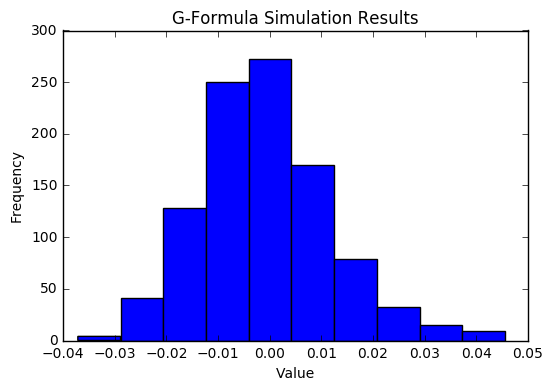

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

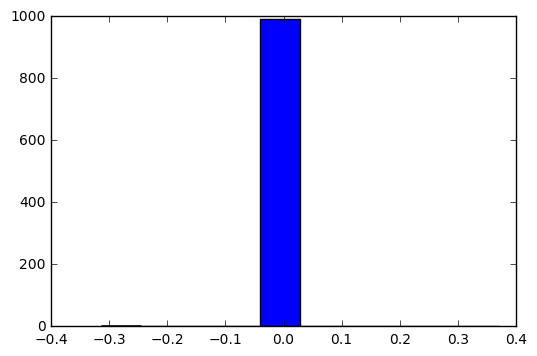

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [1136]:
results_effect_df2

trace1 = go.Histogram(
    x=results_effect_df2.differenceg,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_effect_df2.differencedr,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram_weffect')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


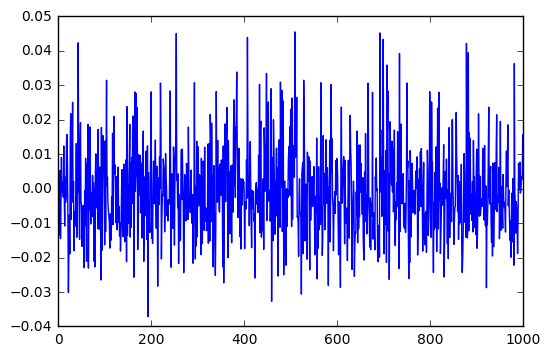

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

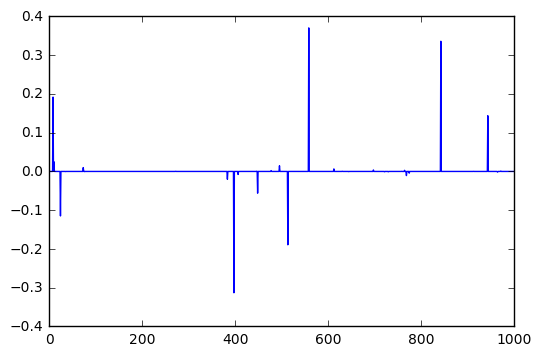

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001